## 0c: Scripts to create volume/runoff/meltwater timeseries for the summed up characteristics of every region (RGI region, PROVIDE region or basin-wide) by always only selecting the common running glaciers 
- creates `../data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500_bc_1980_2019.nc`
- creates `../data/common_running_sum_all_basins_oversh_stab_2000_2500_bc_1980_2019.nc`
- creates `'../data/common_running_sum_all_rgi_reg_extended_oversh_stab_over_10000years_1980_2019.nc'`

- also creates some additional merged data for side analysis 
    - aggregating runs w. both bias correction periods (1980-2019 and 2000-2019) for comparison between the two approaches by using the common running glaciers of both periods together
        - creates `../data/additional_data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500.nc`


In [9]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
from time import gmtime, strftime
import json
import oggm
import sys
sys.path.append('../B_main_analysis_figure_creation') # to be able to import analysis_func
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
# get the correct colors for the different scenarios
from analysis_func import color_scenario, label_scenario, provide_reg_full_name_dict, color_scenario_poster

palette = sns.color_palette(color_scenario.values())
scenarios = color_scenario.keys()

frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

In [10]:
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']

The notebook was once run with `compare_between_bc=False` and once with `compare_between_bc=True`
- only the RGI region aggregated file is aggregated for both bias correction approaches

In [13]:
compare_between_bc = True
if compare_between_bc:
    all_running_rgis_d = {}
    bcs =  ['_bc_1980_2019', '_bc_2000_2019']
    for bc in ['_bc_1980_2019', '_bc_2000_2019']:
        pd_working = pd.read_csv(f'../data/additional_data/working_rgis_for_oversh_stab_scenarios{bc}.csv', index_col='rgiid')
        all_running_rgis_d[bc] = pd_working[scenarios].dropna().index.values
        print(len(all_running_rgis_d[bc]))
    all_running_rgis = list(set(all_running_rgis_d['_bc_1980_2019']).intersection(all_running_rgis_d['_bc_2000_2019']))
    pd_working_all = pd_working.loc[all_running_rgis][['area','all_running_rgis', 'rgi_reg']] 
else:
    bc = '_bc_2000_2019' #'_bc_1980_2019' # more glaciers/glacier area works for this bc option
    bcs = [bc]
    pd_working_all = pd.read_csv(f'../data/additional_data/working_rgis_for_oversh_stab_scenarios{bc}.csv', index_col='rgiid')[['area','all_running_rgis', 'rgi_reg']]
    all_running_rgis = pd_working_all.dropna().index.values

212759
211915


**RGI region aggregated data**

In [14]:
bcs

['_bc_1980_2019', '_bc_2000_2019']

In [15]:
# aggregate RGI regions
load=True
# do the same for the provide regions with runoff 
if load:
    df_scenario_bc_l= []
    for bc in bcs:
        df = []
        for rgi_reg in pd_working_all.rgi_reg.unique():
            if rgi_reg < 10:
                Rreg = f'0{rgi_reg}'
            else:
                Rreg = f'{rgi_reg}'
            print(Rreg)
            dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/A_runs_pre_postprocessing/output/rgi_reg'
            # amount of glaciers in that rgi region
            #rgi_reg_glaciers = pd_geodetic.loc[pd_geodetic.reg==int(rgi_reg)].index
            rgi_reg_glaciers_working = pd_working_all.loc[pd_working_all.rgi_reg == rgi_reg]['all_running_rgis'].dropna().index.values

            with xr.open_mfdataset(f'{dpath}/{Rreg}/rgi_reg_{Rreg}_*_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc') as ds:
                ds_a = ds[['runoff', 'volume', 'area', 'melt_off_on','volume_bsl']].sel(rgi_id=rgi_reg_glaciers_working)
                ds_a = ds.sum(dim='rgi_id').load()
                # maybe this is a bit faster 
                #ds_m = ds[['runoff_monthly', 'melt_off_on_monthly']].sel(rgi_id=rgi_reg_glaciers_working).sum(dim='rgi_id')
                #ds_a[['runoff_monthly', 'melt_off_on_monthly']] = ds_m.load()
                ds_a.coords['rgi_reg'] = Rreg
                df.append(ds_a)
        df_scenario_bc= xr.concat(df, dim='rgi_reg', fill_value=np.NaN)
        df_scenario_bc.coords['bias_correction'] = bc[1:]
        df_scenario_bc_l.append(df_scenario_bc)
    df_scenario_common_rgi_reg = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
    # clean up and document the dataset
    if compare_between_bc:
        bc_add = 'and both bias correction periods\n(data only used to compare influence of bias correction period)'
        bc_info = 'here 1980-2019 or 2000-2019'
    else:
        bc_add = ''
        bc_info = 'here 1980-2019'
    aggregation_level = f'aggregated per RGI6 region (rgi_reg) for the common running glaciers of all scenarios {bc_add}'
    creation_date = strftime("%Y-%m-%d", gmtime())  # here add the current time for info
    #df_scenario_common = df_scenario_common.drop_dims('gcm')
    df_scenario_common_rgi_reg = df_scenario_common_rgi_reg.drop(['hydro_year', 'calendar_year','hydro_month', 'calendar_month','OGGM_version'])
    df_scenario_common_rgi_reg.attrs = {'info': 'Glacier volume, area, and runoff projections from 2000 to 2500 with the glacier model OGGM under the GFDL-ESM2M climate scenarios',
                                'aggregation_level': aggregation_level,
                                'version':'OGGM v1.6.1 with preprocessed gdirs 2023.3',
                               'creation_date': creation_date, 
                               'reference': 'Schuster et al., in review'} # also add todays date for info
    df_scenario_common_rgi_reg.coords['scenario'].attrs['description'] = 'used scenario (here overshoot or stabilisation scenario)'
    df_scenario_common_rgi_reg.coords['bias_correction'].attrs={'bias correction period': bc_info}
    ### 
    df_scenario_common_rgi_reg.volume.attrs = {'unit':'m3', 'description':'Aggregated glacier volume sum at the first day of the year'}
    df_scenario_common_rgi_reg.volume_bsl.attrs = {'unit':'m3',
                                                   'description':'Aggregated glacier volume sum below sea-level at the first day of the year'}

    df_scenario_common_rgi_reg.area.attrs = {'unit':'m2', 'description':'Aggregated glacier area sum at the first day of the year'}
    df_scenario_common_rgi_reg.runoff.attrs = {'unit':'kg yr-1', 
                           'description':'Annual glacier runoff: sum of annual melt and liquid precipitation on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}

    df_scenario_common_rgi_reg.melt_off_on.attrs = {'unit':'kg yr-1', 
                                'description':'Annual meltwater components from glacier runoff: sum of meltwater on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}

    
    if compare_between_bc:
        df_scenario_common_rgi_reg.to_netcdf(f'../data/additional_data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500.nc')
    else:
        df_scenario_common_rgi_reg.to_netcdf(f'../data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500{bc}.nc')

else:
    if compare_between_bc:
        df_scenario_common_rgi_reg = xr.open_dataset(f'../data/additional_data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500.nc')
    else:
        df_scenario_common_rgi_reg = xr.open_dataset(f'../data/common_running_sum_all_rgi_reg_oversh_stab_2000_2500{bc}.nc')

02


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 4683 times more chunks
  return self.array[key]


13


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 13401 times more chunks
  return self.array[key]


12
14


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 6836 times more chunks
  return self.array[key]


15


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 3224 times more chunks
  return self.array[key]


01


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 6703 times more chunks
  return self.array[key]


05


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 4735 times more chunks
  return self.array[key]


08
10
17


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 3893 times more chunks
  return self.array[key]


04
16
03
11
19
07
18
06
09
02


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 4683 times more chunks
  return self.array[key]


13


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 13401 times more chunks
  return self.array[key]


12
14


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 6836 times more chunks
  return self.array[key]


15


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 3224 times more chunks
  return self.array[key]


01


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 6703 times more chunks
  return self.array[key]


05


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 4735 times more chunks
  return self.array[key]


08
10
17


/home/users/lschuster/mambaforge/envs/oggm_gmip3_working/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 3893 times more chunks
  return self.array[key]


04
16
03
11
19
07
18
06
09


**Random climate for 10000 years**

In [5]:
len(all_running_rgis)

212759

In [6]:
if compare_between_bc==False:
    bc='_bc_1980_2019'
    ## random climate     
    pd_working_random_stab = pd.read_csv(f'../data/additional_data/random_climate_run_10000years_working_rgis_for_oversh_stab_scenarios{bc}.csv',
                                         index_col='rgiid')
    pd_working_random_stab = pd_working_random_stab.loc[all_running_rgis] # take only those that also work for all other scenarios (e.g. also stab_T12)

    # random climate after year 2500 for RGI regions
    load=True
    # do the same for the provide regions with runoff 
    if load :
        df_scenario_bc_l= []
        for bc in [bc]:
            df = []
            for rgi_reg in pd_working_all.rgi_reg.unique():
                if rgi_reg < 10:
                    Rreg = f'0{rgi_reg}'
                else:
                    Rreg = f'{rgi_reg}'
                print(Rreg)
                dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/A_runs_pre_postprocessing/output/rgi_reg'
                # amount of glaciers in that rgi region
                rgi_reg_glaciers_working = pd_working_random_stab.loc[pd_working_random_stab.rgi_reg == rgi_reg]['all_running_rgis'].dropna().index.values

                with xr.open_mfdataset(f'{dpath}/{Rreg}/random_climate_from2500_using2399_2499_rgi_reg_*_w5e5_gcm_merged_from_2000{bc}.nc') as ds:
                    ds_a = ds[['volume']].sel(rgi_id=rgi_reg_glaciers_working).sel(time=slice(0,101*100))
                    # we don't look into the "zero state" 
                    ds_a = ds_a.sel(scenario=['initial state: oversh_T30OS15 after 500 years',
                                               'initial state: stab_T15 after 500 years'])
                    ds_a = ds_a.sum(dim='rgi_id').load()
                    # maybe this is a bit faster 
                    ds_a.coords['rgi_reg'] = Rreg
                    df.append(ds_a)
            df_scenario_bc= xr.concat(df, dim='rgi_reg', fill_value=np.NaN)
            df_scenario_bc.coords['bias_correction'] = bc[1:]
            df_scenario_bc_l.append(df_scenario_bc)
        df_scenario_random = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
        # clean up and document the dataset
        bc_add = ''
        bc_info = 'here 1980-2019'
        aggregation_level = f'aggregated per RGI6 region (rgi_reg) for the common running glaciers of all scenarios {bc_add} over the >10000 years'
        creation_date = strftime("%Y-%m-%d", gmtime())  # here add the current time for info
        df_scenario_random = df_scenario_random.drop(['hydro_year', 'calendar_year','hydro_month', 'calendar_month','OGGM_version'])

        df_scenario_random.coords['gcm'] = ['GFDL-ESM2M repeated 2399-2499 climate']  # add GCM as a coordinate
        df_scenario_random.coords['gcm'].attrs['description'] = 'used global circulation model'  # add a description for GCM
        df_scenario_random.coords['scenario'].attrs['description'] = '2399-2499 stab_T15 used as GCM, initial state from the chosen scenario after 500 years'
        df_scenario_random.attrs = {'info': 'Glacier volume projections from the 2500 state onwards for more than 10000 years by using randomly repeated climate from 2399-2499 stab_T15 GFDL-ESM2M',
                                            'initial state': 'Initial state (time=0) chosen from the respective 2500 state of the GFDL-ESM2M projections of the chosen scenario',
                                            'aggregation_level': aggregation_level,
                                            'version':'OGGM v1.6.1 with preprocessed gdirs 2023.3',
                                            'creation_date': creation_date, 
                                            'reference': 'Schuster et al., in review'} # also add todays date for info
        df_scenario_random.coords['bias_correction'].attrs={'bias correction period': bc_info}
        ### 
        df_scenario_random.volume.attrs = {'unit':'m3', 'description':'Aggregated glacier volume sum at the first day of the year'}

        df_scenario_random.to_netcdf(f'../data/additional_data/common_running_random_climate_stab_T15_sum_all_rgi_reg_oversh_stab{bc}.nc')
        
        #################################
        # aggregate the rgi regions from 2000 to 2500
        # by using the common running glaciers from the extended scenario random run
        df_scenario_bc_l= []
        df = []
        for rgi_reg in pd_working_all.rgi_reg.unique():
            if rgi_reg < 10:
                Rreg = f'0{rgi_reg}'
            else:
                Rreg = f'{rgi_reg}'
            print(Rreg)
            dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/A_runs_pre_postprocessing/output/rgi_reg'
            # amount of glaciers in that rgi region
            #rgi_reg_glaciers = pd_geodetic.loc[pd_geodetic.reg==int(rgi_reg)].index
            rgi_reg_glaciers_working = pd_working_random_stab.loc[pd_working_random_stab.rgi_reg == rgi_reg]['all_running_rgis'].dropna().index.values
            with xr.open_mfdataset(f'{dpath}/{Rreg}/rgi_reg_{Rreg}_*_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc') as ds:
                ds_a = ds[['volume']].sel(rgi_id=rgi_reg_glaciers_working)
                ds_a = ds_a.sum(dim='rgi_id').load()
                # maybe this is a bit faster 
                #ds_m = ds[['runoff_monthly', 'melt_off_on_monthly']].sel(rgi_id=rgi_reg_glaciers_working).sum(dim='rgi_id')
                #ds_a[['runoff_monthly', 'melt_off_on_monthly']] = ds_m.load()
                ds_a.coords['rgi_reg'] = Rreg
                df.append(ds_a)
        df_scenario_bc= xr.concat(df, dim='rgi_reg', fill_value=np.NaN)
        df_scenario_bc.coords['bias_correction'] = bc[1:]
        df_scenario_bc_l.append(df_scenario_bc)
        df_scenario_common_of_random_runs = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
        
        # clean up and document the dataset
        bc_info = 'here 1980-2019'
        aggregation_level = f'aggregated per RGI6 region (rgi_reg) for the common running glaciers of all scenarios until 2500 and of the common running glaciers of the two random climate options over >10000 years'
        creation_date = strftime("%Y-%m-%d", gmtime())  # here add the current time for info
        #df_scenario_common = df_scenario_common.drop_dims('gcm')
        df_scenario_common_of_random_runs = df_scenario_common_of_random_runs.drop(['hydro_year', 'calendar_year','hydro_month', 'calendar_month','OGGM_version'])
        df_scenario_common_of_random_runs.attrs = {'info': 'Glacier volume projections from 2000 to 2500 with the glacier model OGGM under the GFDL-ESM2M climate scenarios'+
                                            '\n(only used for analysing the long-term stabilisation/overshoot effects, see aggregation_level info)',
                                    'aggregation_level': aggregation_level,
                                    'version':'OGGM v1.6.1 with preprocessed gdirs 2023.3',
                                   'creation_date': creation_date, 
                                   'reference': 'Schuster et al., in review'} # also add todays date for info
        df_scenario_common_of_random_runs.coords['scenario'].attrs['description'] = 'used scenario (here only the stab_T15 and oversh_T30OS15)'
        df_scenario_common_of_random_runs.coords['bias_correction'].attrs={'bias correction period': bc_info}
        df_scenario_common_of_random_runs.volume.attrs = {'unit':'m3', 'description':'Aggregated glacier volume sum at the first day of the year'}
        df_scenario_common_of_random_runs = df_scenario_common_of_random_runs.sel(scenario=['stab_T15','oversh_T30OS15'])
        df_scenario_common_of_random_runs.to_netcdf(f'../data/additional_data/common_running_of_random_runs_sum_all_rgi_reg_oversh_stab_2000_2500{bc}.nc')
        
        
        ### quick check if the differences in year 2500 are the same 
        # this should be the case as we start in df_scenario_random, with the values from df_scenario_common_of_random_runs
        _p_r = df_scenario_random.volume.sum(dim='rgi_reg').sel(time=0)/df_scenario_common_of_random_runs.volume.sum(dim='rgi_reg').sel(time=2020).mean().values
        _p_r_diff = _p_r.isel(scenario=0)- _p_r.isel(scenario=1)
        _p = df_scenario_common_of_random_runs.volume.sum(dim='rgi_reg').sel(time=2500)/df_scenario_common_of_random_runs.volume.sum(dim='rgi_reg').sel(time=2020)
        _p_diff =  _p.sel(scenario='oversh_T30OS15') - _p.sel(scenario='stab_T15')
        np.testing.assert_allclose(_p_r_diff,_p_diff)
        
        
        # merge them together ... 
        df_scenario_random = df_scenario_random.sel(scenario=['initial state: stab_T15 after 500 years',
                                                              'initial state: oversh_T30OS15 after 500 years'])# .volume
        df_scenario_random.coords['time'] = df_scenario_random.coords['time']+2500
        scenarios_extended = ['stab_T15_extended_w_2399-2499_stab_T15','oversh_T30OS15_extended_w_2399-2499_stab_T15']
        df_scenario_random.coords['scenario'] = scenarios_extended
        df_scenario_common_of_random_runs.coords['scenario'] = scenarios_extended 
        df_scenario_random.coords['gcm'] = ['GFDL-ESM2M_extended']
        df_scenario_common_of_random_runs.coords['gcm'] = ['GFDL-ESM2M_extended']

        df_scenario_extended = xr.concat([df_scenario_common_of_random_runs.sel(scenario=df_scenario_random.scenario), df_scenario_random], dim='time')
        scenarios_extended_description =  'oversh_T30OS15 or stab_T15 from year 2000 to 2500, after 2500 random climate from the 2399-2499 stab_T15 scenario climate used for more than 10000 years'
        df_scenario_extended.attrs['info'] = 'Glacier volume projections over >10000 years with the glacier model OGGM by using an extended overshoot and stabilisation scenario of the the GFDL-ESM2M climate (see scenario attributes)'
        df_scenario_extended.coords['scenario'].attrs['description']  = scenarios_extended_description
        df_scenario_extended.to_netcdf('../data/common_running_sum_all_rgi_reg_extended_oversh_stab_over_10000years_{bc}.nc')
        # analysed in http://localhost:7261/lab/tree/www_lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/analysis_notebooks/
        #schuster_el_al_phd_paper_2_overshoot_glaciers/4_steady_state_glacier_tipping_points.ipynb
df_scenario_extended = xr.open_dataset('../data/common_running_sum_all_rgi_reg_extended_oversh_stab_over_10000years_1980_2019.nc')

01


/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


02


/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


03
04
05


/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


06
07
08
09
10
11
12
13


/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


14


/home/users/lschuster/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


15
16
17
18
19
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19


**basin aggregated data**

In [18]:
if compare_between_bc==False:
    load=False
    # do the same for the basins with runoff 
    if load:
        # common running per basin 
        df_scenario_bc_l= []
        b_per_Preg = json.load(open('/home/www/lschuster/provide/provide_glacier_regions/basin_ids_per_provide_region.json'))

        for bc in bcs:
            df = []
            for preg in np.arange(1,14,1):
                print(preg)
                if preg < 10:
                    Preg = f'P0{preg}'
                else:
                    Preg = f'P{preg}'
                dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/A_runs_pre_postprocessing/output/provide_reg'
                # amount of glaciers int that rgi region
                #rgi_reg_glaciers = pd_geodetic.loc[pd_geodetic.reg==int(rgi_reg)].index
                with xr.open_mfdataset(f'{dpath}/{Preg}/provide_reg_{Preg}_*_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc') as ds:
                    #print(len(work_rgis),len(rgi_reg_glaciers_working))
                    for basin in b_per_Preg[Preg]:
                        basin = str(basin)
                        basin_glaciers_working = pd_working_all.loc[pd_working_all.basin == basin].index.values
                        ds_sum = ds.sel(rgi_id=basin_glaciers_working).load().sum(dim='rgi_id')
                        ds_sum['basin'] = basin
                        ds_sum['provide_region'] = Preg
                        df.append(ds_sum)
            df_scenario_bc= xr.concat(df, dim='basin', fill_value=np.NaN)
            df_scenario_bc.coords['bias_correction'] = bc[1:]
            df_scenario_bc_l.append(df_scenario_bc)
        df_scenario_common_basin = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
        aggregation_level = 'aggregated per Global Runoff Data Centre (GRDC) basin for the common running glaciers of all scenarios'   
        df_scenario_common_basin = df_scenario_common_basin.drop(['hydro_year','hydro_month','calendar_year','calendar_month','calendar_month_2d', 'OGGM_version'])
        df_scenario_common_basin.attrs = {'info': 'Glacier volume, area and runoff projections from 2000 to 2500 with the glacier model OGGM under the GFDL-ESM2M climate scenarios',
                                    'aggregation_level': aggregation_level,
                                    'version':'OGGM v1.6.1 with preprocessed gdirs 2023.3',
                                   'creation_date': creation_date, 
                                   'reference': 'Schuster et al., in review'} # also add todays date for info
        df_scenario_common_basin.coords['scenario'].attrs['description'] = 'used scenario (here overshoot or stabilisation scenario)'
        df_scenario_common_basin.coords['bias_correction'].attrs={'bias correction period': 'here 1980-2019'}
        ### 
        df_scenario_common_basin.volume.attrs = {'unit':'m3', 'description':'Aggregated glacier volume sum at the first day of the year'}
        df_scenario_common_basin.area.attrs = {'unit':'m2', 'description':'Aggregated glacier area sum at the first day of the year'}
        df_scenario_common_basin.runoff.attrs = {'unit':'kg yr-1', 
                               'description':'Annual glacier runoff: sum of annual melt and liquid precipitation on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}
        df_scenario_common_basin.runoff_monthly.attrs = {'unit':'kg month-1',
                                       'description':'Monthly glacier runoff from sum of monthly melt and liquid precipitation on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}
        df_scenario_common_basin.melt_off_on_monthly.attrs = {'unit':'kg yr-1',
                                            'description':'Monthly meltwater components from glacier runoff: sum of meltwater on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}
        df_scenario_common_basin.melt_off_on.attrs = {'unit':'kg yr-1', 
                                    'description':'Annual meltwater components from glacier runoff: sum of meltwater on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}

        
        
        if compare_between_bc:
            df_scenario_common_basin.to_netcdf(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500.nc')
        else:
            df_scenario_common_basin.to_netcdf(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500{bc}.nc')
    else:
        if compare_between_bc:
            df_scenario_common_basin = xr.open_dataset(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500.nc')
        else:
            df_scenario_common_basin = xr.open_dataset(f'../data/common_running_sum_all_basins_oversh_stab_2000_2500{bc}.nc')

# Old code -> to be removed

### Not anymore used:  **Aggregate to PROVIDE regions** <--- 

In [ ]:
## 
agg_provide_reg= False
if agg_provide_reg: 
    for pi in np.arange(1,14,1):
        f = open('/home/www/lschuster/provide/provide_glacier_regions/rgi_ids_per_provide_region.json')
        if pi<10:
            Preg = f'P0{pi}'
        else:
            Preg = f'P{pi}'
        rgis_basin = json.load(f)[Preg]
        # remove connectivity level 2 glaciers only important for P03 (Greenland)
        rgis_basin = odf.loc[rgis_basin].loc[odf.loc[rgis_basin].Connect <2].index.values
        rgis_basin_w = list(set(rgis_basin).intersection(pd_working_all.index))
        pd_working_all.loc[rgis_basin_w,'provide_reg'] = Preg

    if compare_between_bc==False:

        load=False
        # do the same for the provide regions with runoff 
        if load:
            df_scenario_bc_l= []
            for bc in bcs:
                df = []
                for preg in np.arange(1,14,1):
                    if preg < 10:
                        Preg = f'P0{preg}'
                    else:
                        Preg = f'P{preg}'
                    print(Preg)
                    dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/A_runs_pre_postprocessing/output/provide_reg'
                    # amount of glaciers in that rgi region
                    #rgi_reg_glaciers = pd_geodetic.loc[pd_geodetic.reg==int(rgi_reg)].index
                    rgi_reg_glaciers_working = pd_working_all.loc[pd_working_all.provide_reg == Preg]['all_running_rgis'].dropna().index.values

                    with xr.open_mfdataset(f'{dpath}/{Preg}/provide_reg_{Preg}_*_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc') as ds:
                        ds_a = ds[['runoff', 'volume', 'area', 'melt_off_on']].sel(rgi_id=rgi_reg_glaciers_working)
                        ds_a = ds.sum(dim='rgi_id').load()
                        # maybe this is a bit faster 
                        ds_m = ds[['runoff_monthly', 'melt_off_on_monthly']].sel(rgi_id=rgi_reg_glaciers_working).sum(dim='rgi_id')
                        ds_a[['runoff_monthly', 'melt_off_on_monthly']] = ds_m.load()
                        df.append(ds_a)
                df_scenario_bc= xr.concat(df, dim='provide_region', fill_value=np.NaN)
                df_scenario_bc.coords['bias_correction'] = bc[1:]
                df_scenario_bc_l.append(df_scenario_bc)
            df_scenario_common = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
            # clean up and document the dataset
            aggregation_level = 'aggregated per PROVIDE region for the common running glaciers of all scenarios'

            creation_date = strftime("%Y-%m-%d", gmtime())  # here add the current time for info
            #df_scenario_common = df_scenario_common.drop_dims('gcm')
            df_scenario_common = df_scenario_common.drop(['hydro_year','hydro_month','calendar_year','calendar_month','calendar_month_2d', 'OGGM_version'])
            df_scenario_common.attrs = {'info': 'Glacier volume, area and runoff projections from 2000 to 2500 with the glacier model OGGM under the GFDL-ESM2M climate scenarios',
                                        'aggregation_level': aggregation_level,
                                        'version':'OGGM v1.6.1 with preprocessed gdirs 2023.3',
                                       'creation_date': creation_date, 
                                       'reference': 'Schuster et al., in review'} # also add todays date for info
            df_scenario_common.coords['scenario'].attrs['description'] = 'used scenario (here overshoot or stabilisation scenario)'
            df_scenario_common.coords['bias_correction'].attrs={'bias correction perion': 'here 1980-2019'}
            ### 
            df_scenario_common.volume.attrs = {'unit':'m3', 'description':'Aggregated glacier volume sum at the first day of the year'}
            df_scenario_common.area.attrs = {'unit':'m2', 'description':'Aggregated glacier area sum at the first day of the year'}
            df_scenario_common.runoff.attrs = {'unit':'kg yr-1', 
                                   'description':'Annual glacier runoff: sum of annual melt and liquid precipitation on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}
            df_scenario_common.runoff_monthly.attrs = {'unit':'kg month-1',
                                           'description':'Monthly glacier runoff from sum of monthly melt and liquid precipitation on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}
            df_scenario_common.melt_off_on_monthly.attrs = {'unit':'kg yr-1',
                                                'description':'Monthly meltwater components from glacier runoff: sum of meltwater on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}
            df_scenario_common.melt_off_on.attrs = {'unit':'kg yr-1', 
                                        'description':'Annual meltwater components from glacier runoff: sum of meltwater on and off the glacier using a fixed-gauge with a glacier minimum reference area from year 2000'}


            if compare_between_bc:
                df_scenario_common.to_netcdf(f'../data/common_running_sum_all_provide_reg_oversh_stab_2000_2500.nc')
            else:
                df_scenario_common.to_netcdf(f'../data/common_running_sum_all_provide_reg_oversh_stab_2000_2500{bc}.nc')

        else:
            if compare_between_bc:
                df_scenario_common = xr.open_dataset(f'../data/common_running_sum_all_provide_reg_oversh_stab_2000_2500.nc')
            else:
                df_scenario_common = xr.open_dataset(f'../data/common_running_sum_all_provide_reg_oversh_stab_2000_2500{bc}.nc')
        # just check that at the beginning it is roughly the same 
        assert (df_scenario_common.runoff.sel(time=slice(2000,2020)).std(dim='scenario')/df_scenario_common.runoff.sel(time=slice(2000,2020)).mean(dim='scenario')).max() < 0.01
        assert (df_scenario_common.volume.sel(time=slice(2000,2020)).std(dim='scenario')/df_scenario_common.volume.sel(time=slice(2000,2020)).mean(dim='scenario')).max() <0.02

# The below filled approach is old -> to remove at the end ...

## Differences between applying common running glaciers or a filling approach:

In [8]:
df = xr.open_dataset('filled_sum_all_provide_reg_oversh_stab_2000_2500.nc')

In [9]:
diff = (df_scenario_common.volume.sel(provide_region='P11')-df.volume.sel(provide_region='P11'))/df.volume.sel(provide_region='P11')
pd_vol_scenario_rel_diff = (diff).to_dataframe('diff').reset_index()
paletti = list(color_scenario.values())     

In [10]:
bc = 'bc_1980_2019' # 'bc_1980_2019' #,

Text(0.5, 1.0, 'P11: differences between common running and filled scenarios')

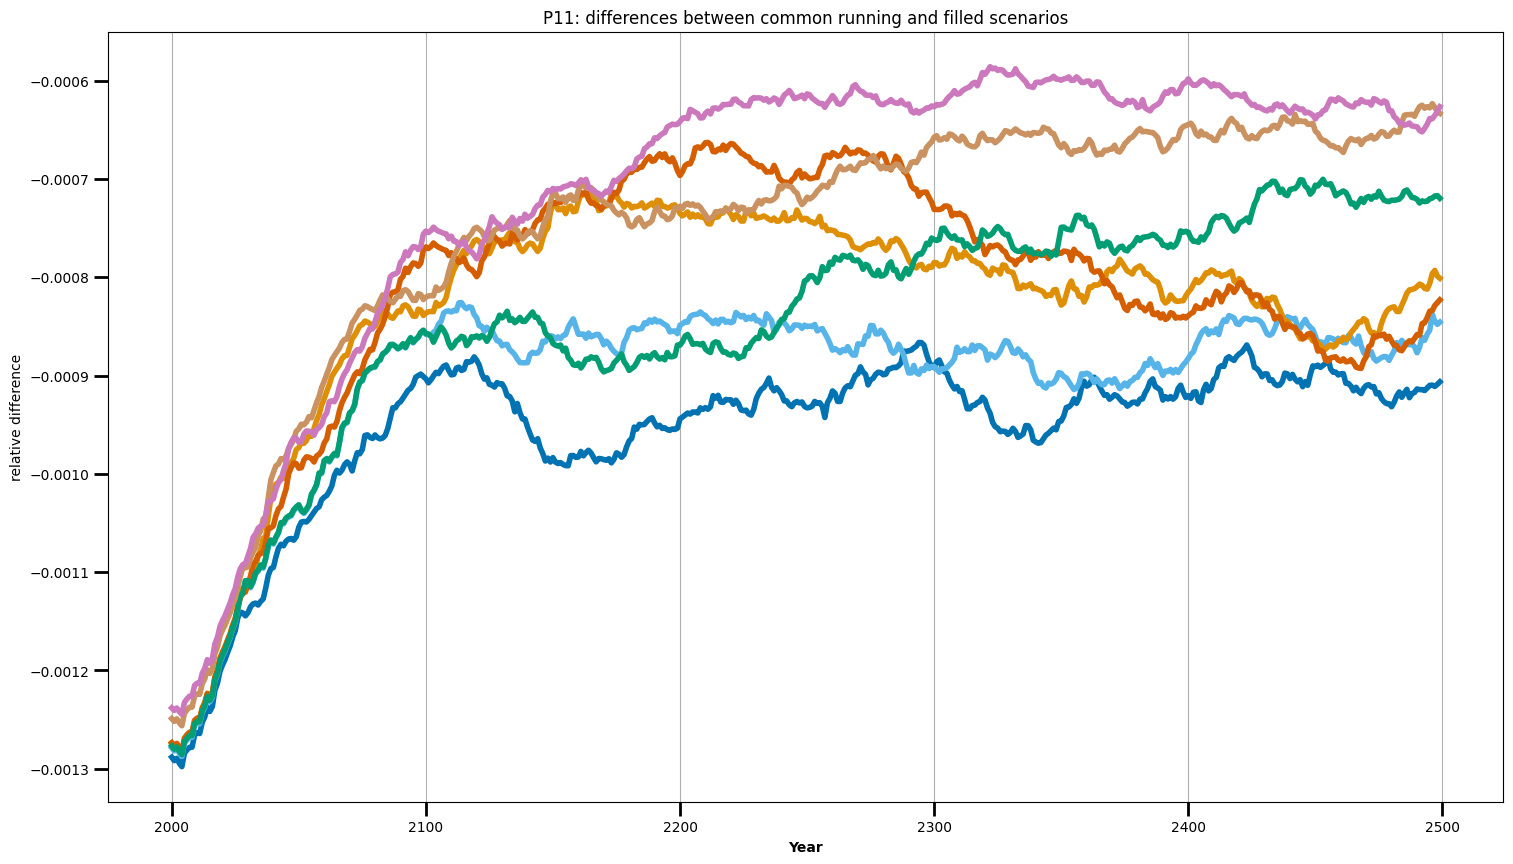

In [11]:
fig, ax = plt.subplots(1,1, figsize=(18,10), sharex=True)
sns.lineplot(data=pd_vol_scenario_rel_diff.loc[pd_vol_scenario_rel_diff.bias_correction==bc],
             hue='scenario', x='time', y= 'diff', 
             palette=paletti,
             hue_order=scenarios,lw=4, legend=False,
             ax = ax)
ax.set_xlabel('Year',  weight='bold')
ax.tick_params(axis='both', which='major', width=2, length=10)
ax.grid(axis='x')
plt.ylabel('relative difference')
plt.title('P11: differences between common running and filled scenarios')